In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, auc, confusion_matrix


In [3]:
df = pd.read_csv('/content/sample_data/diabetic_data.csv')
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies feature engineering to the cleaned dataset.

    Args:
        df: The cleaned pandas DataFrame.

    Returns:
        A pandas DataFrame with new, engineered features.
    """
    df_eng = df.copy()

    # 1. Simplify Diagnosis Codes into Clinical Groups
    # Grouping based on ICD-9 code ranges. This reduces dimensionality and creates more meaningful features.
    diag_cols = ['diag_1', 'diag_2', 'diag_3']
    for col in diag_cols:
        # Using .loc to avoid SettingWithCopyWarning
        df_eng.loc[:, col] = df_eng[col].str.slice(0, 3)
        codes = pd.to_numeric(df_eng[col], errors='coerce').fillna(0).astype(int)

        df_eng[f'{col}_group'] = 'Other'
        df_eng.loc[codes.between(390, 459) | (codes == 785), f'{col}_group'] = 'Circulatory'
        df_eng.loc[codes.between(250, 251), f'{col}_group'] = 'Diabetes'
        df_eng.loc[codes.between(460, 519) | (codes == 786), f'{col}_group'] = 'Respiratory'
        df_eng.loc[codes.between(800, 999), f'{col}_group'] = 'Injury'
        df_eng.loc[codes.between(710, 739), f'{col}_group'] = 'Musculoskeletal'
        df_eng.loc[df_eng[col].astype(str).str.contains('V|E', na=False), f'{col}_group'] = 'ExternalCauses'

    # 2. Create Service Utilization Features
    df_eng['service_utilization'] = (
        df_eng['number_outpatient'] + df_eng['number_emergency'] + df_eng['number_inpatient']
    )

    # 3. Create Medication Change Feature
    # A change in medication (Up/Down) is a strong indicator of patient instability.
    med_cols = [
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
        'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
        'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
        'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone'
    ]
    # Filter list to only include columns present in the dataframe
    med_cols_present = [col for col in med_cols if col in df_eng.columns]

    df_eng['med_change_count'] = df_eng[med_cols_present].isin(['Up', 'Down']).sum(axis=1)

    # 4. Number of medications taken
    df_eng['num_meds'] = (df_eng[med_cols_present] != 'No').sum(axis=1)

    return df_eng

In [4]:
#Reading cleaned dataset
df_cleaned = pd.read_csv('/content/sample_data/cleaned_diabetic_data.csv')

#Featured dataset
df_featured = engineer_features(df_cleaned)

#Dropping Original diagnosis columns and the patient identifier
cols_to_drop = ['diag_1', 'diag_2', 'diag_3', 'patient_nbr']
df_model = df_featured.drop(columns=cols_to_drop, axis=1)
df_model['readmitted_less_than_30_days'] = (df['readmitted'] == '<30').astype(int)
df_model.head()
print(df_model.readmitted_less_than_30_days.value_counts(dropna=False))

readmitted_less_than_30_days
0    63397
1     8118
Name: count, dtype: int64


In [5]:
#Defining features(X) and target(y)
X = df_model.drop('readmitted_less_than_30_days', axis=1)
y = df_model['readmitted_less_than_30_days']

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train.value_counts(normalize=True)

,proportion
readmitted_less_than_30_days,
0,0.886492
1,0.113508


In [6]:
#Processing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))
    ],
    remainder='passthrough' # Keep any columns that are not num/cat (if any)
)

In [7]:
#Logistic Regression(L1 vs L2 Regularization)
# L2 (Ridge) Regularization
pipe_lr_l2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', random_state=42))
])
pipe_lr_l2.fit(X_train, y_train)

# L1 (Lasso) Regularization
pipe_lr_l1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
])
pipe_lr_l1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79a1e91069d0>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79a1e9e1d1d0>)])),
                ('classifier',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [8]:
# Defining models and parameter grids for GridSearchCV
models_to_tune = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_leaf': [5, 10]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [4, 6],
        'classifier__learning_rate': [0.1, 0.2]
    })
}

In [9]:
# Store results
best_estimators = {
    'LogisticRegression_L1': pipe_lr_l1,
    'LogisticRegression_L2': pipe_lr_l2,
}

In [10]:
print("\n--- Starting GridSearchCV for Tree-Based Models ---")
for name, (model, params) in models_to_tune.items():
    print(f"Tuning {name}...")
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])

    # Using AUPRC for scoring is critical for imbalanced datasets
    grid_search = GridSearchCV(pipeline, params, cv=3, scoring='average_precision', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best score (AUPRC) for {name}: {grid_search.best_score_:.4f}")
    print(f"Best params for {name}: {grid_search.best_params_}\n")
    best_estimators[name] = grid_search.best_estimator_


--- Starting GridSearchCV for Tree-Based Models ---
Tuning RandomForest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score (AUPRC) for RandomForest: 0.1117
Best params for RandomForest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 200}

Tuning XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:10:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best score (AUPRC) for XGBoost: 0.1126
Best params for XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}



#Model Evaluation

Model LogisticRegression_L1 AUPRC: 0.1138
Model LogisticRegression_L2 AUPRC: 0.1132
Model RandomForest AUPRC: 0.1121
Model XGBoost AUPRC: 0.1151


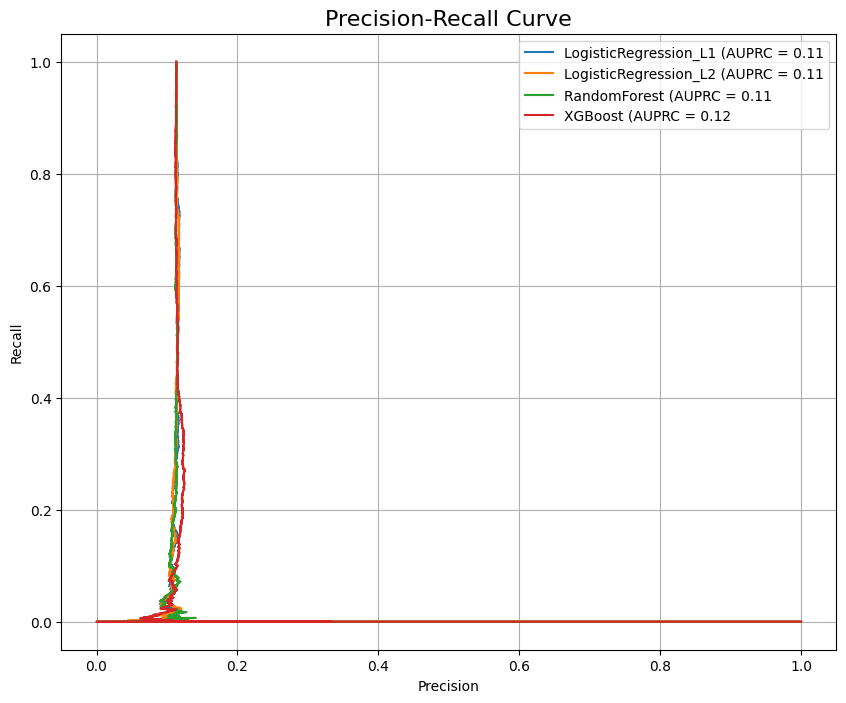

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
for name, model in best_estimators.items():
  y_pred_prob = model.predict_proba(X_test)[:,1]
  average_pr_score = average_precision_score(y_test, y_pred_prob)
  print(f"Model {name} AUPRC: {average_pr_score:.4f}")

  #Plot PR Curve
  precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
  ax.plot(precision, recall, label=f'{name} (AUPRC = {average_pr_score:.2f}')

ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve', fontsize=16)
ax.legend()
ax.grid(True)
plt.show()

#Select the best model and show detailed report

In [13]:
best_model_name = max(best_estimators, key=lambda name: average_precision_score(y_test, best_estimators[name].predict_proba(X_test)[:, 1]))
best_model = best_estimators[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"AUPRC: {average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1]):.4f}")

Best Model: XGBoost
AUPRC: 0.1151


#Detailed classification report

In [14]:
y_pred_best = best_model.predict(X_test)
print('\nClassification report:')
print(classification_report(y_test, y_pred_best, target_names=['Not Readmitted', 'Readmitted']))


Classification report:
                precision    recall  f1-score   support

Not Readmitted       0.89      1.00      0.94     12679
    Readmitted       0.17      0.00      0.00      1624

      accuracy                           0.89     14303
     macro avg       0.53      0.50      0.47     14303
  weighted avg       0.80      0.89      0.83     14303



#Confusion matrix

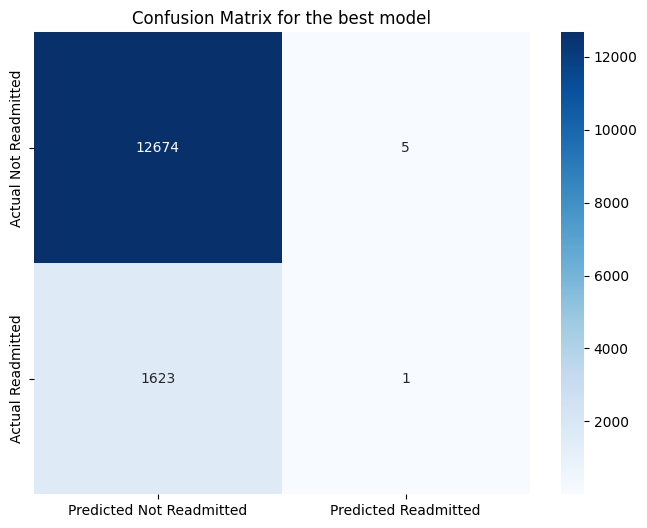

In [17]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Readmitted', 'Predicted Readmitted'], yticklabels=['Actual Not Readmitted', 'Actual Readmitted'])
plt.title('Confusion Matrix for the best model')
plt.show()

#Serializing the best model

In [18]:
model_path = '/content/sample_data/best_model.pkl'
joblib.dump(best_model, model_path)

['/content/sample_data/best_model.pkl']